In [1]:
import os
import numpy as np
import doubletdetection
import scanpy as sc
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

## Parameters

In [2]:
# This parameters cell will be overridden by values specified at execution time.
sample_name = "test"
path_h5ad = "../test/test.raw.h5ad"
path_out = "../test"

n_jobs = 8
p_thresh=1e-16
voter_thresh=0.5

In [3]:
sc.settings.n_jobs=n_jobs
sc.set_figure_params()

## Load

In [4]:
adata = sc.read_h5ad(path_h5ad)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
adata.var_names_make_unique()

## Apply Minimum Filters

In [6]:
# remove "empty" genes
sc.pp.filter_genes(adata, min_cells=1)

/Users/chunj/opt/miniconda3/envs/dev/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


## Run

In [7]:
clf = doubletdetection.BoostClassifier(
    n_iters=25,
    use_phenograph=False,
    standard_scaling=True
)

doublets = clf.fit(adata.X).predict(
    p_thresh=p_thresh, voter_thresh=voter_thresh)
doublet_score = clf.doublet_score()

In [8]:
doublets

array([0., 0., 0., ..., 0., 0., 0.])

In [9]:
doublet_score

masked_array(data=[0.0001685339072040694, 0.09097418094870942,
                   8.199006212189992, ..., 6.3684969029650856e-24,
                   0.0001685339072040694, 3.00242493008347],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

In [10]:
np.count_nonzero(doublets)

10

In [11]:
adata.obs["doublet"] = doublets
adata.obs["doublet_score"] = doublet_score

## Write to Disk

In [12]:
with open(os.path.join(path_out, f"{sample_name}.doublets.pickle"), "wb") as fout:
   pickle.dump(doublets, fout)

In [13]:
with open(os.path.join(path_out, f"{sample_name}.doublet-score.pickle"), "wb") as fout:
   pickle.dump(doublet_score, fout)

## Visualize

### Convergence of Doublet Calls

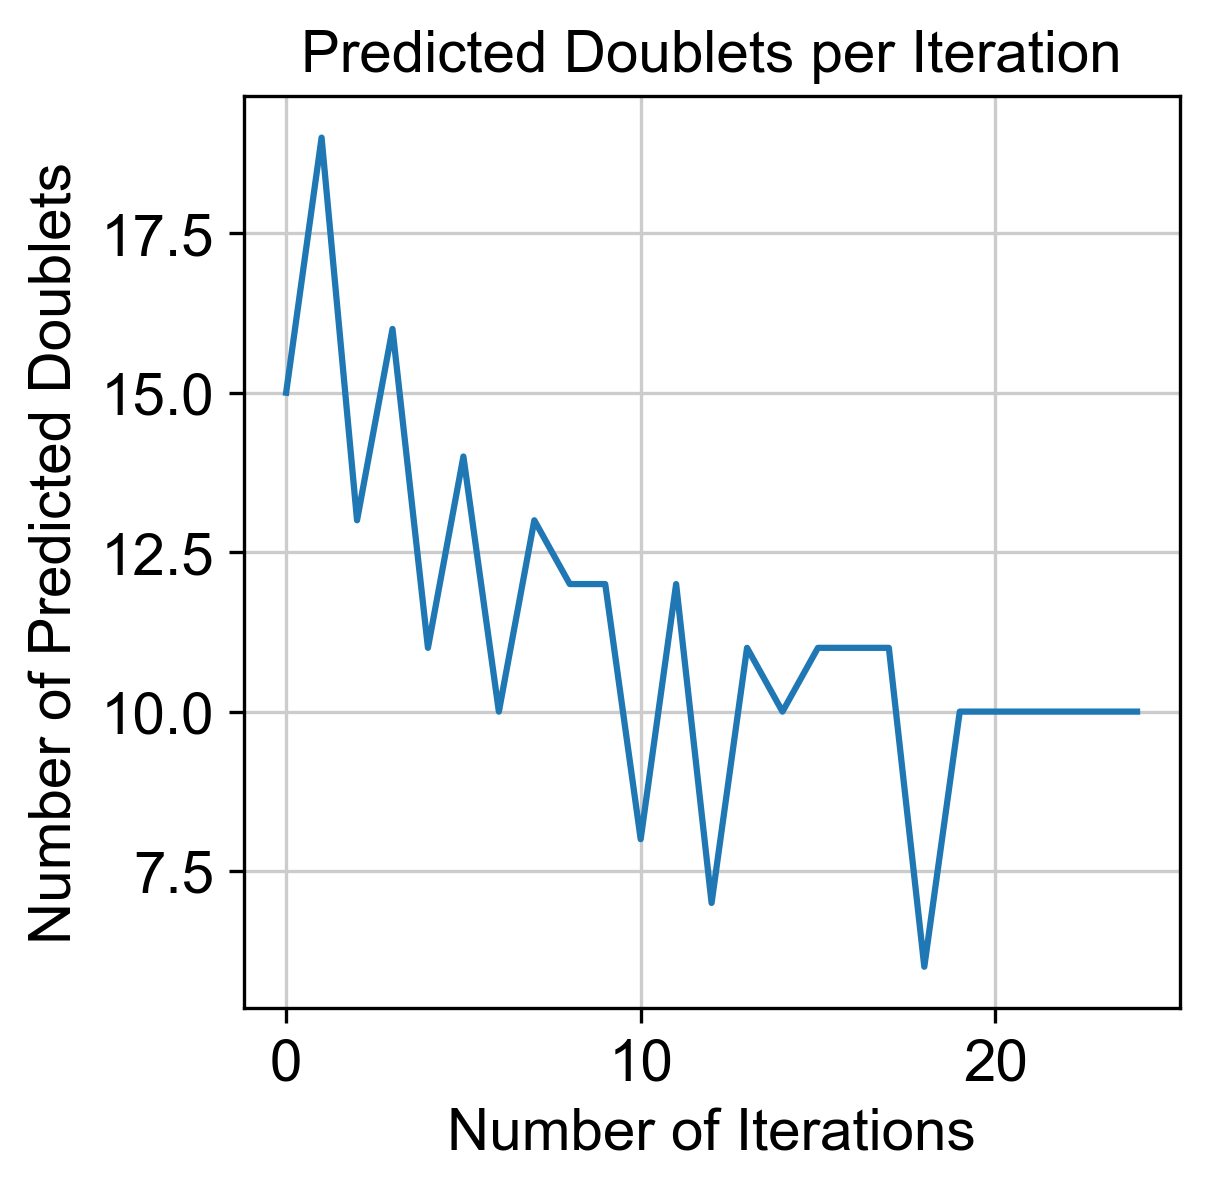

In [14]:
f = doubletdetection.plot.convergence(
    clf,
    show=True,
    p_thresh=p_thresh,
    voter_thresh=voter_thresh
)

### Doublets on UMAP

In [15]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/Users/chunj/opt/miniconda3/envs/dev/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [16]:
adata

AnnData object with n_obs × n_vars = 5941 × 1347
    obs: 'doublet', 'doublet_score'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'read_counts'
    obsp: 'distances', 'connectivities'

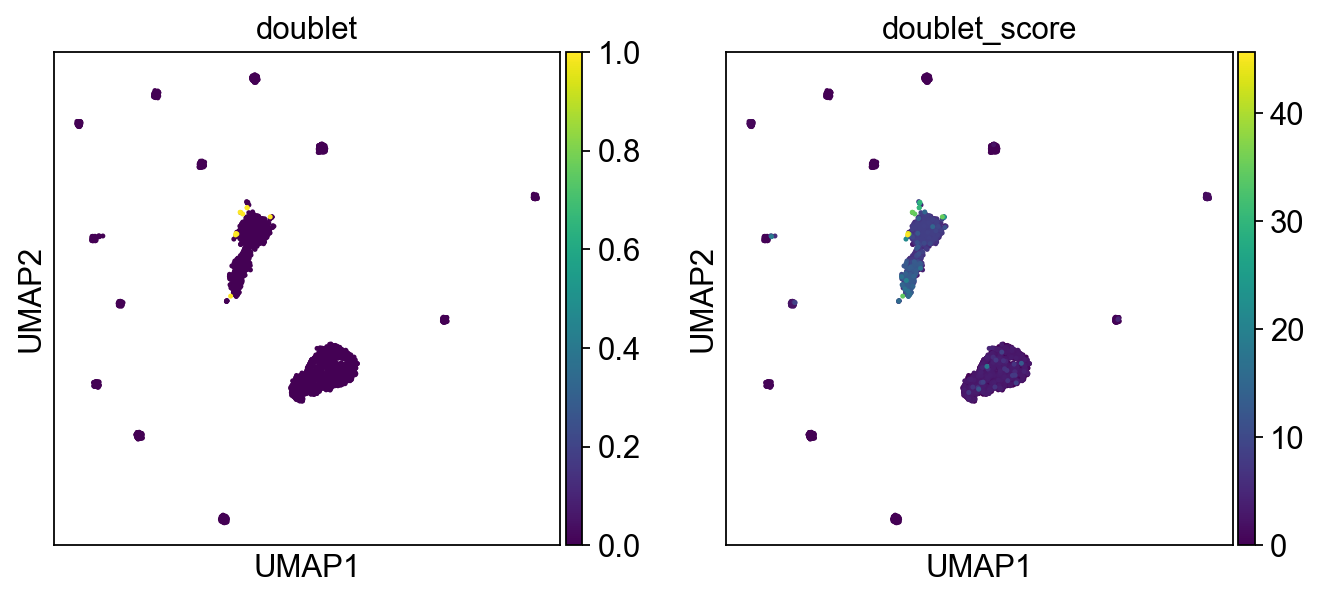

In [17]:
sc.pl.umap(
    adata,
    color=["doublet", "doublet_score"],
    
)

### Violin Plot of Doublet Score

/Users/chunj/opt/miniconda3/envs/dev/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/chunj/opt/miniconda3/envs/dev/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


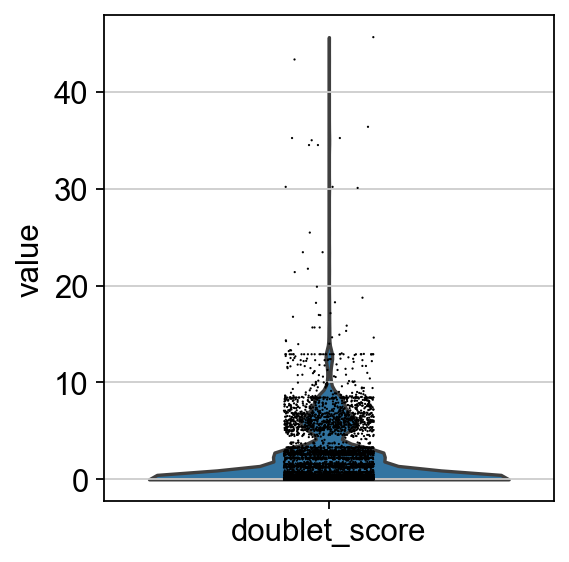

In [18]:
sc.pl.violin(adata, "doublet_score")

### Num of Predicted Doublets at Different Threshold Combinations

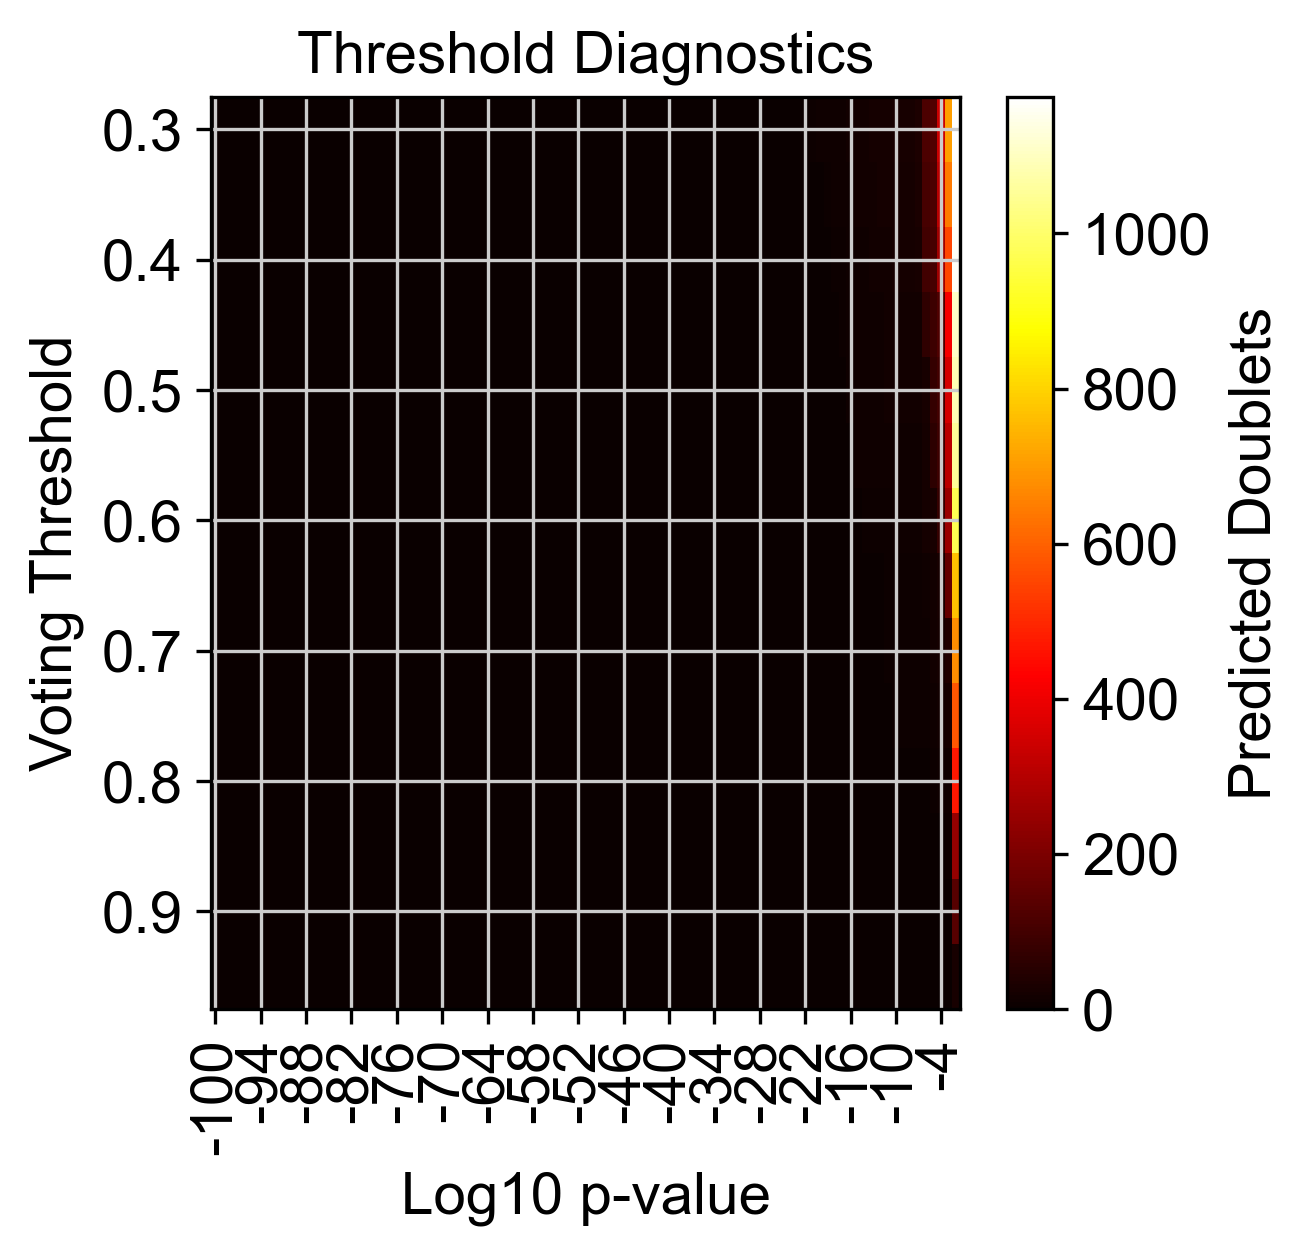

In [19]:
f3 = doubletdetection.plot.threshold(
    clf,
    show=True,
    p_step=6
)